## 01. 노드 학습 내용 정리

#### 01-1 tsfresh 라이브러리 사용한 전처리
- 시계열 데이터 전처리, feature extraction에 특화된 라이브러리

In [1]:
# ① tsfresh 라이브러리 설치
!pip install tsfresh # tsfresh 라는 라이브러리 사용

In [2]:
# # ② 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9) # colab에서는 필요 없을 듯 함

In [3]:
# ③ robot execution 데이터셋 다운로드 및 불러오기
# tsfresh 내에는
# driftbif_simulation
# har_dataset
# robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [4]:
# ④ 불러온 데이터 확인
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


##### x_feature의 row수는 1320개인데, y의 row수는 88개
- x_feature의 row수와 y의 row수를 맞추려면 어떻게 해야 할까?
- id별로 맞추면 됨

In [6]:
timeseries.shape

(1320, 8)

In [16]:
import pandas as pd
timeseries['id'].nunique()

88

In [7]:
y.shape

(88,)

In [9]:
# ⑤ 특징 추출(feature extraction)
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id",column_sort="time")
extracted_features.head()

Feature Extraction: 100%|██████████| 528/528 [00:52<00:00, 10.02it/s]


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variation_coefficient,F_x__variance,F_x__skewness,F_x__kurtosis,F_x__root_mean_square,F_x__absolute_sum_of_changes,F_x__longest_strike_below_mean,F_x__longest_strike_above_mean,F_x__count_above_mean,F_x__count_below_mean,F_x__last_location_of_maximum,F_x__first_location_of_maximum,F_x__last_location_of_minimum,F_x__first_location_of_minimum,F_x__percentage_of_reoccurring_values_to_all_values,F_x__percentage_of_reoccurring_datapoints_to_all_datapoints,F_x__sum_of_reoccurring_values,F_x__sum_of_reoccurring_data_points,F_x__ratio_value_number_to_time_series_length,F_x__sample_entropy,F_x__maximum,F_x__absolute_maximum,F_x__minimum,F_x__benford_correlation,F_x__time_reversal_asymmetry_statistic__lag_1,F_x__time_reversal_asymmetry_statistic__lag_2,F_x__time_reversal_asymmetry_statistic__lag_3,...,T_z__number_crossing_m__m_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_0,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_2,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_3,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_4,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_5,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_6,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_7,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_8,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_9,T_z__ratio_beyond_r_sigma__r_0.5,T_z__ratio_beyond_r_sigma__r_1,T_z__ratio_beyond_r_sigma__r_1.5,T_z__ratio_beyond_r_sigma__r_2,T_z__ratio_beyond_r_sigma__r_2.5,T_z__ratio_beyond_r_sigma__r_3,T_z__ratio_beyond_r_sigma__r_5,T_z__ratio_beyond_r_sigma__r_6,T_z__ratio_beyond_r_sigma__r_7,T_z__ratio_beyond_r_sigma__r_10,T_z__count_above__t_0,T_z__count_below__t_0,T_z__lempel_ziv_complexity__bins_2,T_z__lempel_ziv_complexity__bins_3,T_z__lempel_ziv_complexity__bins_5,T_z__lempel_ziv_complexity__bins_10,T_z__lempel_ziv_complexity__bins_100,T_z__fourier_entropy__bins_2,T_z__fourier_entropy__bins_3,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,-0.933333,15.0,0.249444,-0.267261,0.062222,3.872983,15.000000,0.966092,2.0,13.0,1.0,1.0,14.0,0.133333,0.066667,1.000000,0.000000,0.500000,0.933333,-1.0,-14.0,0.133333,0.182322,0.0,1.0,-1.0,0.864123,-0.076923,-0.090909,-0.111111,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,-0.866667,15.0,0.956847,-1.104054,0.915556,-1.317311,1.348311,1.290994,14.0,3.0,3.0,6.0,9.0,0.933333,0.200000,0.733333,0.333333,1.000000,1.000000,-4.0,-13.0,0.200000,1.011601,0.0,3.0,-3.0,0.877632,1.000000,0.545455,0.222222,...,0.0,0.000000,0.00,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,1.0,0.266667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.733333,1.000000,0.466667,0.466667,0.466667,0.466667,0.466667,0.562335,0.562335,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,NaN,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,-0.666667,15.0,0.596285,-0.894427,0.355556,1.791551,2.6

In [11]:
extracted_features.shape

(88, 4698)

In [24]:
#extract_features # 함수 쳐보면, hyperparameter와 관련 문서 링크, .py형태 source-code도 확인가능!

#### Feature추출 후의 전처리
- impute
  - -inf는 min값으로 대체
  - +inf는 max값으로 대체
  - Nan은 median으로 대체
- select_features(X,y)
  - feature중 중요한 feature만 반환

In [20]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute # imputation 함수 호출!

In [22]:
# select_features

In [25]:
# ⑥ impute
impute(extracted_features)

# ⑦ select_features(X, y)
features_filtered = select_features(extracted_features, y)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [27]:
# ⑧ 필터링된 값 확인
features_filtered.head()

,F_x__value_count__value_-1,F_x__abs_energy,F_x__root_mean_square,T_y__absolute_maximum,F_x__mean_n_absolute_max__number_of_maxima_7,F_x__range_count__max_1__min_-1,F_y__abs_energy,F_y__root_mean_square,F_y__mean_n_absolute_max__number_of_maxima_7,T_y__standard_deviation,T_y__variance,F_y__absolute_maximum,T_x__absolute_maximum,"F_x__fft_coefficient__attr_""abs""__coeff_1",F_x__absolute_maximum,"T_y__fft_coefficient__attr_""abs""__coeff_1",T_y__root_mean_square,T_y__abs_energy,T_y__mean_n_absolute_max__number_of_maxima_7,F_z__standard_deviation,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",F_z__variance,F_x__variance,F_x__standard_deviation,F_x__ratio_value_number_to_time_series_length,T_x__standard_deviation,T_x__variance,"T_x__fft_coefficient__attr_""abs""__coeff_1","T_y__fft_coefficient__attr_""abs""__coeff_2",F_x__cid_ce__normalize_True,F_x__autocorrelation__lag_1,F_x__partial_autocorrelation__lag_1,T_y__percentage_of_reoccurring_datapoints_to_all_datapoints,T_x__mean_n_absolute_max__number_of_maxima_7,"T_y__fft_coefficient__attr_""abs""__coeff_4",T_x__ratio_value_number_to_time_series_length,F_x__lempel_ziv_complexity__bins_100,"F_z__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_y__fft_coefficient__attr_""abs""__coeff_0",T_y__percentage_of_reoccurring_values_to_all_values,...,"T_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","F_x__fft_aggregated__aggtype_""centroid""","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6",T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_5,"F_y__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","T_y__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_z__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",T_x__count_below__t_0,F_z__count_above_mean,F_z__permutation_entropy__dimension_5__tau_1,"T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4","F_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.4",F_x__count_below_mean,T_y__fourier_entropy__bins_3,F_z__time_reversal_asymmetry_statistic__lag_2,T_y__permutation_entropy__dimension_6__tau_1,"T_z__fft_aggregated__aggtype_""variance""",T_x__permutation_entropy__dimension_5__tau_1,F_z__maximum,"F_z__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.4",T_z__variation_coefficient,"T_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",T_x__number_peaks__n_1,T_y__number_cwt_peaks__n_1,T_y__count_below__t_0,"T_x__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0","F_z__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",T_x__quantile__q_0.1,F_y__has_duplicate_max,T_y__lempel_ziv_complexity__bins_3,T_y__quantile__q_0.1,F_z__time_reversal_asymmetry_statistic__lag_1,F_x__quantile__q_0.2,F_y__quantile__q_0.7,F_z__permutation_entropy__dimension_4__tau_1,"T_x__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0",T_z__large_standard_deviation__r_0.35000000000000003
1,14.0,14.0,0.966092,1.0,1.000000,15.0,13.0,0.930949,1.000000,0.471405,0.222222,1.0,3.0,1.000000,1.0,1.165352,0.816497,10.0,1.000000,1.203698,0.65,1.448889,0.062222,0.249444,0.133333,0.339935,0.115556,1.338261,0.870796,5.669467,-0.081633,-0.081633,1.000000,3.000000,4.165352,0.133333,0.333333,61.0,13.0,1.000000,...,0.571429,0.000000,1.333333,0.000000,0.016201,-0.333333,0.0,-1.0,0.000000,1.000000,10.0,2.098274,0.000000,0.0,0.000000,14.0,0.735622,2181.909091,2.302585,4.909978,1.159589,64.0,0.000000,-0.238179,-3.000000,1.0,4.0,1.000000,0.0,0.0,-3.0,1.0,0.400000,-1.0,-596.000000,-1.0,-1.0,1.698783,0.0,0.0
2,7.0,25.0,1.290994,5.0,1.571429,13.0,76.0,2.250926,3.000000,2.054805,4.222222,4.0,10.0,0.624118,3.0,6.020261,2.449490,90.0,3.285714,4.333846,19.84,18.782222,0.915556,0.956847,0.

In [29]:
features_filtered.shape # 4698개에서 674개로 feature가 줄어들었음!

(88, 674)

#### 01-2 시각화, 분류모델 적용
- tsfresh로 전처리 된 데이터를 시각화 및 전처리
- 시계열 데이터 특성상 sklearn의 train_test_split을 바로 사용하는 대신, self로 정의된 함수 사용


In [30]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

##### self 정의된 train/test set 분리 함수

In [31]:
# ⑤ 데이터셋 가공
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum()*test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum())*test_size) # int((88 - 21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    # y==False인것과 y==True인것의 인덱스값을 리스트로 변환하여 더해줍니다.
    # y[y==False].head(num_false).index.to_list()는 19~38까지의 값이 리스트로
    # y[y==True].head(num_true).index.to_list()는 1~6까지의 값이 리스트로
    # id_list는 19~38 + 1~6이 더해진 리스트입니다.

    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다.
    y_test = y.iloc[id_list].sort_index()                # 19~38, 1~6이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용하는 것입니다.
    X_test = x[x['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [32]:
# 커스텀한 함수를 적용한 데이터셋이 어떤 차이가 있는지 확인해봅시다.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)
print(X_train)
print('-'*50)
print(y_train)
print('-'*50)
print(X_test)
print('-'*50)
print(y_test)

      id  time  F_x  F_y  F_z  T_x  T_y  T_z
90     7     0   -3    1   53  -10   -4    0
91     7     1    0   -2   65   -4   -1    0
92     7     2   -1   -1   56   -7   -3    0
93     7     3    0   -2   60   -6    0    0
94     7     4   -1   -1   57   -7   -4    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[930 rows x 8 columns]
--------------------------------------------------
7      True
8      True
9      True
10     True
11     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 62, dtype: bool
--------------------------------------------------
     id  time  F_x  F_y  F_z  T_x  T_y  T_z
0     1     0   -1   -1   63   -3   -1    0
1     1     1    0    0   62   -3   -1    0
2     1     2   -1   -1   61   -3    0    0
3 

##### 데이터 수 대비 feature수가 너무 많으므로 MinimalFCParameters적용

In [35]:
# ⑥ 특징 추출하기
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

In [37]:
# MinimalFCParameters # settings.py라는 소스코드 확인 가능

In [38]:
settings = MinimalFCParameters() # 하이퍼파라미터 따로 지정X
minimal_features_train = extract_features(
                                X_train,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )

minimal_features_test = extract_features(
                                X_test,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )

Feature Extraction: 100%|██████████| 156/156 [00:00<00:00, 2992.30it/s]


In [39]:
# ⑦ 추출된 특징 확인
minimal_features_train.shape # feature수가 674에서 60개로 줄어든 것 확인!

(62, 60)

In [41]:
minimal_features_train.head()

,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,F_y__sum_values,F_y__median,F_y__mean,F_y__length,F_y__standard_deviation,F_y__variance,F_y__root_mean_square,F_y__maximum,F_y__absolute_maximum,F_y__minimum,F_z__sum_values,F_z__median,F_z__mean,F_z__length,F_z__standard_deviation,F_z__variance,F_z__root_mean_square,F_z__maximum,F_z__absolute_maximum,F_z__minimum,T_x__sum_values,T_x__median,T_x__mean,T_x__length,T_x__standard_deviation,T_x__variance,T_x__root_mean_square,T_x__maximum,T_x__absolute_maximum,T_x__minimum,T_y__sum_values,T_y__median,T_y__mean,T_y__length,T_y__standard_deviation,T_y__variance,T_y__root_mean_square,T_y__maximum,T_y__absolute_maximum,T_y__minimum,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
7,-13.0,-1.0,-0.866667,15.0,0.805536,0.648889,1.183216,0.0,3.0,-3.0,-15.0,-1.0,-1.000000,15.0,0.894427,0.800000,1.341641,1.0,2.0,-2.0,882.0,57.0,58.800000,15.0,5.243409,27.493333,59.033324,70.0,70.0,50.0,-107.0,-7.0,-7.133333,15.0,1.995551,3.982222,7.407204,-3.0,10.0,-10.0,-52.0,-4.0,-3.466667,15.0,1.892676,3.582222,3.949684,0.0,7.0,-7.0,-1.0,0.0,-0.066667,15.0,0.442217,0.195556,0.447214,1.0,1.0,-1.0
8,-10.0,-1.0,-0.666667,15.0,1.135292,1.288889,1.316561,2.0,2.0,-2.0,2.0,0.0,0.133333,15.0,1.257864,1.582222,1.264911,3.0,3.0,-3.0,887.0,60.0,59.133333,15.0,4.364503,19.048889,59.294182,69.0,69.0,50.0,-143.0,-10.0,-9.533333,15.0,2.305549,5.315556,9.808160,-5.0,13.0,-13.0,-43.0,-3.0,-2.866667,15.0,2.445858,5.982222,3.768289,2.0,6.0,-6.0,0.0,0.0,0.000000,15.0,1.032796,1.066667,1.032796,3.0,3.0,-1.0
9,-10.0,-1.0,-0.666667,15.0,1.074968,1.155556,1.264911,2.0,3.0,-3.0,12.0,1.0,0.800000,15.0,1.833030,3.360000,2.000000,5.0,5.0,-2.0,880.0,58.0,58.666667,15.0,4.027682,16.222222,58.804762,69.0,69.0,51.0,-168.0,-11.0,-11.200000,15.0,2.688246,7.226667,11.518102,-8.0,18.0,-18.0,-57.0,-4.0,-3.800000,15.0,1.557776,2.426667,4.106905,0.0,7.0,-7.0,3.0,0.0,0.200000,15.0,1.045626,1.093333,1.064581,3.0,3.0,-1.0
10,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,946.0,63.0,63.066667,15.0,0.679869,0.462222,63.070331,64.0,64.0,61.0,-38.0,-3.0,-2.533333,15.0,0.498888,0.248889,2.581989,-2.0,3.0,-3.0,-10.0,-1.0,-0.666667,15.0,0.596285,0.355556,0.894427,0.0,2.0,-2.0,0.0,0.0,0.000000,15.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
11,-13.0,-1.0,-0.866667,15.0,0.956847,0.915556,1.290994,1.0,3.0,-3.0,-11.0,-1.0,-0.733333,15.0,2.542090,6.462222,2.645751,4.0,7.0,-7.0,938.0,63.0,62.533333,15.0,4.814792,23.182222,62.718418,70.0,70.0,52.0,-49.0,-5.0,-3.266667,15.0,3.549022,12.595556,4.823553,6.0,8.0,-8.0,-14.0,-1.0,-0.933333,15.0,1.691810,2.862222,1.932184,2.0,4.0,-4.0,-3.0,0.0,-0.200000,15.0,0.400000,0.160000,0.447214,0.0,1.0,-1.0


In [42]:
minimal_features_train.columns

Index(['F_x__sum_values', 'F_x__median', 'F_x__mean', 'F_x__length',
       'F_x__standard_deviation', 'F_x__variance', 'F_x__root_mean_square',
       'F_x__maximum', 'F_x__absolute_maximum', 'F_x__minimum',
       'F_y__sum_values', 'F_y__median', 'F_y__mean', 'F_y__length',
       'F_y__standard_deviation', 'F_y__variance', 'F_y__root_mean_square',
       'F_y__maximum', 'F_y__absolute_maximum', 'F_y__minimum',
       'F_z__sum_values', 'F_z__median', 'F_z__mean', 'F_z__length',
       'F_z__standard_deviation', 'F_z__variance', 'F_z__root_mean_square',
       'F_z__maximum', 'F_z__absolute_maximum', 'F_z__minimum',
       'T_x__sum_values', 'T_x__median', 'T_x__mean', 'T_x__length',
       'T_x__standard_deviation', 'T_x__variance', 'T_x__root_mean_square',
       'T_x__maximum', 'T_x__absolute_maximum', 'T_x__minimum',
       'T_y__sum_values', 'T_y__median', 'T_y__mean', 'T_y__length',
       'T_y__standard_deviation', 'T_y__variance', 'T_y__root_mean_square',
       'T_y__maximu

##### 추출된 특징 시각화

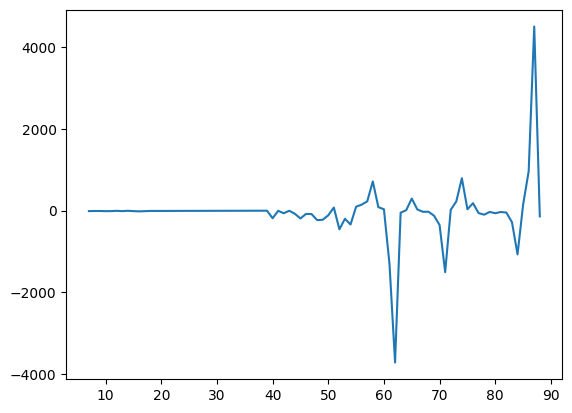

In [43]:
# ⑧ 추출된 특징 시각화하기
plt.plot(minimal_features_train['F_x__sum_values'])
plt.show()

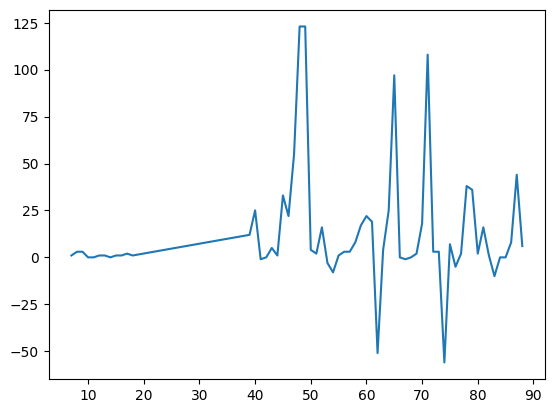

In [44]:
plt.plot(minimal_features_train['T_z__maximum'])
plt.show()

##### 로지스틱 회귀모델로 분류 적용

In [50]:
# ⑨ Logistic Regression 사용하기
logistic = LogisticRegression()
logistic.fit(minimal_features_train, y_train)

LogisticRegression()

In [51]:
# ⑩ Logistic Regression score 확인하기
logistic.score(minimal_features_test, y_test)

0.8461538461538461

In [52]:
# ⑪ 분류 성능 평가 지표 확인하기
# y는 True, False는 Target으로도 표현할 수 있습니다.
classification_report(y_test, logistic.predict(minimal_features_test), target_names=['true', 'false'], output_dict=True)
# y_test 내부에 있는 true, false와 일치하는 이름을 표시합니다.

{'true': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.8888888888888888,
  'support': 20.0},
 'false': {'precision': 0.6, 'recall': 1.0, 'f1-score': 0.75, 'support': 6.0},
 'accuracy': 0.8461538461538461,
 'macro avg': {'precision': 0.8,
  'recall': 0.9,
  'f1-score': 0.8194444444444444,
  'support': 26.0},
 'weighted avg': {'precision': 0.9076923076923078,
  'recall': 0.8461538461538461,
  'f1-score': 0.8568376068376069,
  'support': 26.0}}

## 02. 미니 프로젝트
- 시계열 데이터 중 Airpassenger, robot 데이터 통해 다음과 같은 과제 진행
  - 목표1 : 비정상 데이터를 정상 데이터로 만들기(Airpassenger)
  - 목표2 : 분류 모델 활용하기(robot_execution_failures, tsfresh 내장데이터)
- 제출방법
  - LMS 내 github 링크로 제출
- 과제 진행 순서 (Airpasenger데이터)
  - ① 데이터 불러오기, 시각화 (②~⑤ 통해 정상성 있는 데이터로 변형)
  - ② 분산을 일정하게 만들기 - log transformation
  - ③ 차분을 통해 추세 제거하기
  - ④ (추가) 계절 차분을 통해 계절성 제거하기
  - ⑤ 검정을 통해 정상성 확인하기
  - ⑥ 시계열 분류 (robot_execution_failures)
    - ⑥-1 : 데이터 다운로드 및 불러오기
    - ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
    - ⑥-3 : 데이터셋 가공
    - ⑥-4 : 데이터셋 나누기
    - ⑥-5 : Feature extraction
    - ⑥-6 : impute
    - ⑥-7 : RandomForest 및 XGBoost 사용 및 score 확인
    - ⑥-8 : XGBoost plot_importance 확인 및 시각화
    - ⑥-9 : Classification report를 통한 검증 및 분석

#### ① 데이터 불러오기(Airpassenger), 시각화

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ap = pd.read_csv(url)
print(ap.head())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


In [47]:
# 'Month' column을 삭제합니다.
ap = ap.drop(['Month'], axis=1)

In [48]:
ap.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


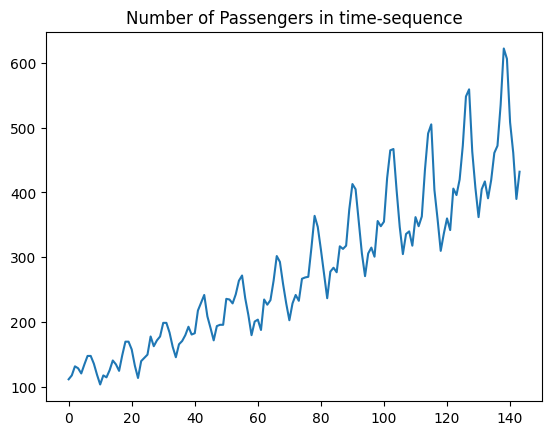

In [49]:
plt.figure()
plt.plot(ap)
plt.title("Number of Passengers in time-sequence") # Month는 제거됨
plt.show()

##### Raw값으로 ADF, KPSS검정 해보기
- ADF p-value 0.82, KPSS p-value 0.01

In [71]:
from statsmodels.tsa.stattools import adfuller, kpss
raw_ADF_test = adfuller(ap['Passengers']) # ADF 검정
raw_KPSS_test = kpss(ap['Passengers']) # Kpss 검정

print('-'*20 +'ADF통계량 출력(raw데이터)','-'*20)
print(f'ADF통계량 : {round(raw_ADF_test[0],2)}') # ADF통계량(제일 처음 튜플 값)
print(f'P-value : {round(raw_ADF_test[1],2)}') # p-value
print(f'usedlag(사용된 지연차 수) : {round(raw_ADF_test[2],2)}') # 0이면 : 시계열의 과거 변화값(lagged differences)을 아예 사용하지 않았다는 뜻
print(f'유효관측치 : {raw_ADF_test[3]}') # 유효한 관측치 수
print("Critical Values:")
for key, value in raw_ADF_test[4].items():
    print(f"   {key}: {value}") # 딕셔너리라 key, value 꺼내야 함 / 유의수준(1%,5%,10% 별 통계량)
print('\n')
print('-'*20 + 'Kpss통계량 출력(raw데이터)')

print(f'KPSS통계량: {round(raw_KPSS_test[0],2)}') # kpss 통계량
print(f'p-value: {round(raw_KPSS_test[1],2)}') # p-value!
print(f'Lags-used: {raw_KPSS_test[2]}') # 사용된 lag 숫자
print('유의수준별 통계량')
for key, value in raw_KPSS_test[3].items():
  print(f'유의수준 {key}: 통계량 {value}')

--------------------ADF통계량 출력(raw데이터) --------------------
ADF통계량 : 0.82
P-value : 0.99
usedlag(사용된 지연차 수) : 13
유효관측치 : 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


--------------------Kpss통계량 출력(raw데이터)
KPSS통계량: 1.65
p-value: 0.01
Lags-used: 8
유의수준별 통계량
유의수준 10%: 통계량 0.347
유의수준 5%: 통계량 0.463
유의수준 2.5%: 통계량 0.574
유의수준 1%: 통계량 0.739


<ipython-input-71-33d4fc76a239>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  raw_KPSS_test = kpss(ap['Passengers']) # Kpss 검정


#### ② log변환 및 시각화

In [72]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

In [73]:
log_transformed.head()

,Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791


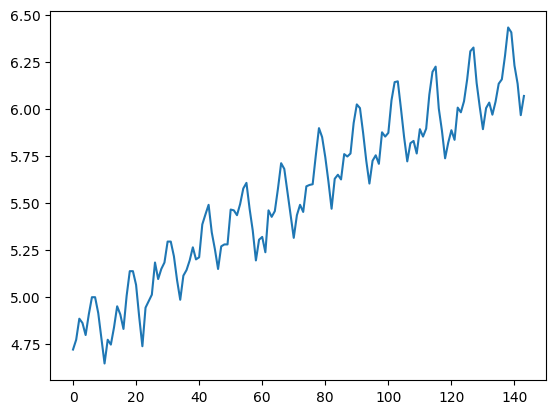

In [74]:
# 분산이 일정해진 것을 눈으로 확인할 수 있습니다.
plt.figure()
plt.plot(log_transformed)
plt.show()

##### log변환값, ADF/KPSS 검정
- ADF p-value 0.42, KPSS p-value 0.01

In [75]:
from statsmodels.tsa.stattools import adfuller, kpss
log_ADF_test = adfuller(log_transformed['Passengers'])
log_KPSS_test = kpss(log_transformed['Passengers'])

print('-'*20 +'ADF통계량 출력(log변환 데이터)','-'*20)
print(f'ADF통계량 : {round(log_ADF_test[0],2)}') # ADF통계량(제일 처음 튜플 값)
print(f'P-value : {round(log_ADF_test[1],2)}') # p-value
print(f'usedlag(사용된 지연차 수) : {round(log_ADF_test[2],2)}') # 0이면 : 시계열의 과거 변화값(lagged differences)을 아예 사용하지 않았다는 뜻
print(f'유효관측치 : {log_ADF_test[3]}') # 유효한 관측치 수
print("Critical Values:")
for key, value in log_ADF_test[4].items():
    print(f"   {key}: {value}") # 딕셔너리라 key, value 꺼내야 함 / 유의수준(1%,5%,10% 별 통계량)
print('\n')
print('-'*20 + 'Kpss통계량 출력(log변환 데이터)')

print(f'KPSS통계량: {round(log_KPSS_test[0],2)}') # kpss 통계량
print(f'p-value: {round(log_KPSS_test[1],2)}') # p-value!
print(f'Lags-used: {log_KPSS_test[2]}') # 사용된 lag 숫자
print('유의수준별 통계량')
for key, value in log_KPSS_test[3].items():
  print(f'유의수준 {key}: 통계량 {value}')

--------------------ADF통계량 출력(log변환 데이터) --------------------
ADF통계량 : -1.72
P-value : 0.42
usedlag(사용된 지연차 수) : 13
유효관측치 : 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


--------------------Kpss통계량 출력(log변환 데이터)
KPSS통계량: 1.67
p-value: 0.01
Lags-used: 8
유의수준별 통계량
유의수준 10%: 통계량 0.347
유의수준 5%: 통계량 0.463
유의수준 2.5%: 통계량 0.574
유의수준 1%: 통계량 0.739


<ipython-input-75-29bb99a6c639>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  log_KPSS_test = kpss(log_transformed['Passengers'])


#### ③ log변환 데이터에 차분 적용

In [76]:
diffed = log_transformed.diff()
diffed.head()

,Passengers
0,NaN
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022


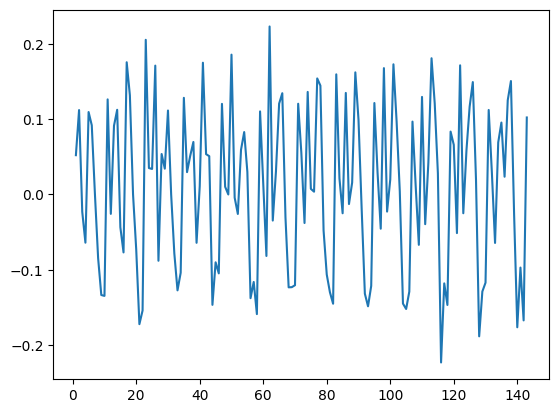

In [77]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()

##### log변환(차분), ADF/KPSS 검정
- ADF p-value 0.07, KPSS p-value 0.1
- (유의수준이 0.1)이라면, ADF는 귀무가설 기각, KPSS는 귀무가설 기각하지 못하므로 정상성 충족한다고 볼 수 있음
- 그런데 여객기 이용객 숫자 이므로 계절성도 고려해보면 어떨까?

In [93]:
from statsmodels.tsa.stattools import adfuller, kpss

tmp = diffed['Passengers'].dropna() # NA제거해야 함 # 참고로 이러면 Series로 나옴
log_diff_ADF_test = adfuller(tmp)
log_diff_KPSS_test = kpss(tmp)

print('-'*20 +'ADF통계량 출력(log변환/차분 데이터)','-'*20)
print(f'ADF통계량 : {round(log_diff_ADF_test[0],2)}') # ADF통계량(제일 처음 튜플 값)
print(f'P-value : {round(log_diff_ADF_test[1],2)}') # p-value
print(f'usedlag(사용된 지연차 수) : {round(log_diff_ADF_test[2],2)}') # 0이면 : 시계열의 과거 변화값(lagged differences)을 아예 사용하지 않았다는 뜻
print(f'유효관측치 : {log_diff_ADF_test[3]}') # 유효한 관측치 수
print("Critical Values:")
for key, value in log_diff_ADF_test[4].items():
    print(f"   {key}: {value}") # 딕셔너리라 key, value 꺼내야 함 / 유의수준(1%,5%,10% 별 통계량)
print('\n')
print('-'*20 + 'Kpss통계량 출력(log변환/차분 데이터)')

print(f'KPSS통계량: {round(log_diff_KPSS_test[0],2)}') # kpss 통계량
print(f'p-value: {round(log_diff_KPSS_test[1],2)}') # p-value!
print(f'Lags-used: {log_diff_KPSS_test[2]}') # 사용된 lag 숫자
print('유의수준별 통계량')
for key, value in log_diff_KPSS_test[3].items():
  print(f'유의수준 {key}: 통계량 {value}')

--------------------ADF통계량 출력(log변환/차분 데이터) --------------------
ADF통계량 : -2.72
P-value : 0.07
usedlag(사용된 지연차 수) : 14
유효관측치 : 128
Critical Values:
   1%: -3.4825006939887997
   5%: -2.884397984161377
   10%: -2.578960197753906


--------------------Kpss통계량 출력(log변환/차분 데이터)
KPSS통계량: 0.04
p-value: 0.1
Lags-used: 6
유의수준별 통계량
유의수준 10%: 통계량 0.347
유의수준 5%: 통계량 0.463
유의수준 2.5%: 통계량 0.574
유의수준 1%: 통계량 0.739


<ipython-input-93-4c3eee643806>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  log_diff_KPSS_test = kpss(tmp)


#### ④ log변환, 차분, 계절성 적용

In [97]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed = seasonally_diffed.dropna()

In [99]:
# 형태를 확인해봅시다.
seasonally_diffed.head()

,Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148


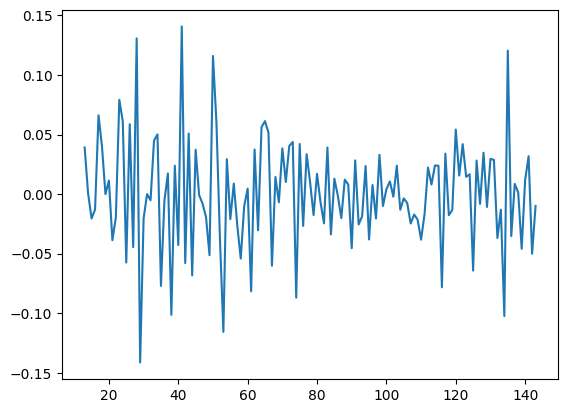

In [100]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

##### log변환(차분, 계절성 포함), ADF/KPSS 검정
- ADF p-value 0.00, KPSS p-value 0.1
- (유의수준 0.05)기준
  - ADF는 귀무가설(정상성X) 기각
  - KPSS는 귀무가설(정상성O) 기각 못함
- 따라서, log변환, 계절성을 포함한 차분 수행 시 정상성이 성립하는 시계열 데이터로 변형 가능함을 확인

In [101]:
def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

In [102]:
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


In [103]:
from statsmodels.tsa.stattools import adfuller, kpss

log_seansonDiff_ADF_test = adfuller(seasonally_diffed)
log_seansonDiff_KPSS_test = kpss(seasonally_diffed)

print('-'*20 +'ADF통계량 출력(log변환/차분 데이터)','-'*20)
print(f'ADF통계량 : {round(log_seansonDiff_ADF_test[0],2)}') # ADF통계량(제일 처음 튜플 값)
print(f'P-value : {round(log_seansonDiff_ADF_test[1],2)}') # p-value
print(f'usedlag(사용된 지연차 수) : {round(log_seansonDiff_ADF_test[2],2)}') # 0이면 : 시계열의 과거 변화값(lagged differences)을 아예 사용하지 않았다는 뜻
print(f'유효관측치 : {log_seansonDiff_ADF_test[3]}') # 유효한 관측치 수
print("Critical Values:")
for key, value in log_seansonDiff_ADF_test[4].items():
    print(f"   {key}: {value}") # 딕셔너리라 key, value 꺼내야 함 / 유의수준(1%,5%,10% 별 통계량)
print('\n')
print('-'*20 + 'Kpss통계량 출력(log변환/차분 데이터)')

print(f'KPSS통계량: {round(log_seansonDiff_KPSS_test[0],2)}') # kpss 통계량
print(f'p-value: {round(log_seansonDiff_KPSS_test[1],2)}') # p-value!
print(f'Lags-used: {log_seansonDiff_KPSS_test[2]}') # 사용된 lag 숫자
print('유의수준별 통계량')
for key, value in log_seansonDiff_KPSS_test[3].items():
  print(f'유의수준 {key}: 통계량 {value}')

--------------------ADF통계량 출력(log변환/차분 데이터) --------------------
ADF통계량 : -4.44
P-value : 0.0
usedlag(사용된 지연차 수) : 12
유효관측치 : 118
Critical Values:
   1%: -3.4870216863700767
   5%: -2.8863625166643136
   10%: -2.580009026141913


--------------------Kpss통계량 출력(log변환/차분 데이터)
KPSS통계량: 0.07
p-value: 0.1
Lags-used: 3
유의수준별 통계량
유의수준 10%: 통계량 0.347
유의수준 5%: 통계량 0.463
유의수준 2.5%: 통계량 0.574
유의수준 1%: 통계량 0.739


<ipython-input-103-57a30a41e23e>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  log_seansonDiff_KPSS_test = kpss(seasonally_diffed)


#### ⑥ 시계열 분류 (robot_execution_failures)

In [104]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [105]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [107]:
timeseries.shape

(1320, 8)

In [108]:
y.head()

,0
1,True
2,True
3,True
4,True
5,True


In [110]:
y.shape

(88,)

In [111]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.25): # 수업 때 보았던 custom split 함수

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다
    y_test =  y.iloc[id_list].sort_index()                # 19~38, 1~6이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)]
    X_test =  x[x['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [112]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)

In [113]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [115]:
import time

st = time.time()

# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

ed = time.time()

print(f'Feature추출 소모 시간 : {round(ed-st,2)}초')

Feature Extraction: 100%|██████████| 402/402 [00:43<00:00,  9.23it/s]


Feature추출 소모 시간 : 43.85초


In [116]:
comprehensive_features_train.shape # 4662개 Feature

(67, 4662)

In [117]:
st = time.time()

comprehensive_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )
ed = time.time()
print(f'Feature추출 소모 시간 : {round(ed-st,2)}초')

Feature Extraction: 100%|██████████| 126/126 [00:15<00:00,  8.34it/s]


Feature추출 소모 시간 : 15.24초


In [118]:
comprehensive_features_test.shape # 4662개 Feature

(21, 4662)

In [119]:
impute(comprehensive_features_train)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variation_coefficient,F_x__variance,F_x__skewness,F_x__kurtosis,F_x__root_mean_square,F_x__absolute_sum_of_changes,F_x__longest_strike_below_mean,F_x__longest_strike_above_mean,F_x__count_above_mean,F_x__count_below_mean,F_x__last_location_of_maximum,F_x__first_location_of_maximum,F_x__last_location_of_minimum,F_x__first_location_of_minimum,F_x__percentage_of_reoccurring_values_to_all_values,F_x__percentage_of_reoccurring_datapoints_to_all_datapoints,F_x__sum_of_reoccurring_values,F_x__sum_of_reoccurring_data_points,F_x__ratio_value_number_to_time_series_length,F_x__maximum,F_x__absolute_maximum,F_x__minimum,F_x__benford_correlation,F_x__time_reversal_asymmetry_statistic__lag_1,F_x__time_reversal_asymmetry_statistic__lag_2,F_x__time_reversal_asymmetry_statistic__lag_3,F_x__c3__lag_1,...,T_z__number_crossing_m__m_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_0,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_2,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_3,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_4,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_5,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_6,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_7,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_8,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_9,T_z__ratio_beyond_r_sigma__r_0.5,T_z__ratio_beyond_r_sigma__r_1,T_z__ratio_beyond_r_sigma__r_1.5,T_z__ratio_beyond_r_sigma__r_2,T_z__ratio_beyond_r_sigma__r_2.5,T_z__ratio_beyond_r_sigma__r_3,T_z__ratio_beyond_r_sigma__r_5,T_z__ratio_beyond_r_sigma__r_6,T_z__ratio_beyond_r_sigma__r_7,T_z__ratio_beyond_r_sigma__r_10,T_z__count_above__t_0,T_z__count_below__t_0,T_z__lempel_ziv_complexity__bins_2,T_z__lempel_ziv_complexity__bins_3,T_z__lempel_ziv_complexity__bins_5,T_z__lempel_ziv_complexity__bins_10,T_z__lempel_ziv_complexity__bins_100,T_z__fourier_entropy__bins_2,T_z__fourier_entropy__bins_3,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,-1.000000,15.0,1.264911,-1.264911,1.600000,0.220316,-0.628205,1.612452,24.0,2.0,1.0,4.0,5.0,1.000000,0.200000,0.600000,0.266667,0.800000,0.933333,-5.0,-15.0,0.333333,1.0,3.0,-3.0,0.975153,-6.153846e-01,-1.090909e+00,2.333333e+00,4.615385e-01,...,0.0,0.200000,0.200000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.333333,0.333333,0.066667,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.733333,0.933333,0.333333,0.533333,0.533333,0.533333,0.533333,0.661563,0.661563,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,-0.866667,15.0,0.805536,-0.929465,0.648889,-1.127280,1.956710,1.183216,13.0,6.0,1.0,5.0,10.0,1.000000,0.066667,0.066667,0.000000,0.500000,0.866667,-1.0,-8.0,0.266667,0.0,3.0,-3.0,0.925356,0.000000e+00,5.454545e-01,1.111111e-01,-4.615385e-01,...,0.0,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.866667,0.933333,0.333333,0.400000,0.400000,0.400000,0.400000,0.562335,0.735622,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.42857

In [120]:
impute(comprehensive_features_test)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variation_coefficient,F_x__variance,F_x__skewness,F_x__kurtosis,F_x__root_mean_square,F_x__absolute_sum_of_changes,F_x__longest_strike_below_mean,F_x__longest_strike_above_mean,F_x__count_above_mean,F_x__count_below_mean,F_x__last_location_of_maximum,F_x__first_location_of_maximum,F_x__last_location_of_minimum,F_x__first_location_of_minimum,F_x__percentage_of_reoccurring_values_to_all_values,F_x__percentage_of_reoccurring_datapoints_to_all_datapoints,F_x__sum_of_reoccurring_values,F_x__sum_of_reoccurring_data_points,F_x__ratio_value_number_to_time_series_length,F_x__maximum,F_x__absolute_maximum,F_x__minimum,F_x__benford_correlation,F_x__time_reversal_asymmetry_statistic__lag_1,F_x__time_reversal_asymmetry_statistic__lag_2,F_x__time_reversal_asymmetry_statistic__lag_3,F_x__c3__lag_1,...,T_z__number_crossing_m__m_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_0,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_1,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_2,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_3,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_4,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_5,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_6,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_7,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_8,T_z__energy_ratio_by_chunks__num_segments_10__segment_focus_9,T_z__ratio_beyond_r_sigma__r_0.5,T_z__ratio_beyond_r_sigma__r_1,T_z__ratio_beyond_r_sigma__r_1.5,T_z__ratio_beyond_r_sigma__r_2,T_z__ratio_beyond_r_sigma__r_2.5,T_z__ratio_beyond_r_sigma__r_3,T_z__ratio_beyond_r_sigma__r_5,T_z__ratio_beyond_r_sigma__r_6,T_z__ratio_beyond_r_sigma__r_7,T_z__ratio_beyond_r_sigma__r_10,T_z__count_above__t_0,T_z__count_below__t_0,T_z__lempel_ziv_complexity__bins_2,T_z__lempel_ziv_complexity__bins_3,T_z__lempel_ziv_complexity__bins_5,T_z__lempel_ziv_complexity__bins_10,T_z__lempel_ziv_complexity__bins_100,T_z__fourier_entropy__bins_2,T_z__fourier_entropy__bins_3,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,-0.933333,15.0,0.249444,-0.267261,0.062222,3.872983,15.000000,0.966092,2.0,13.0,1.0,1.0,14.0,0.133333,0.066667,1.000000,0.000000,0.500000,0.933333,-1.0,-14.0,0.133333,0.0,1.0,-1.0,0.864123,-0.076923,-0.090909,-0.111111,-0.846154,...,0.0,0.554808,0.027806,0.023233,0.020491,0.001143,0.002747,0.000000,0.000000,0.007289,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.562335,0.735622,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,-0.866667,15.0,0.956847,-1.104054,0.915556,-1.317311,1.348311,1.290994,14.0,3.0,3.0,6.0,9.0,0.933333,0.200000,0.733333,0.333333,1.000000,1.000000,-4.0,-13.0,0.200000,0.0,3.0,-3.0,0.877632,1.000000,0.545455,0.222222,-0.307692,...,0.0,0.000000,0.000000,0.500000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,1.000000,0.266667,0.266667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.733333,1.000000,0.466667,0.466667,0.466667,0.466667,0.466667,0.562335,0.562335,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1

In [121]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)
rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [122]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다.
rf_clf.score(comprehensive_features_test, y_test)

0.9047619047619048

In [123]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)
xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [124]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

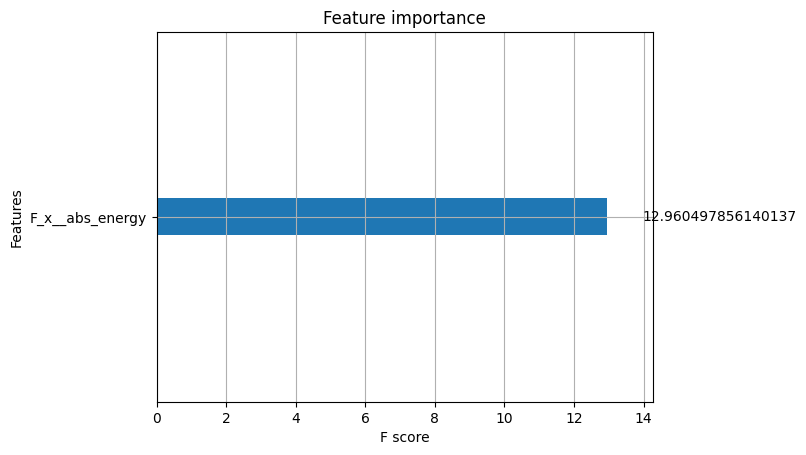

In [125]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [126]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

np.int64(1)

In [127]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}